In [ ]:
%load_ext autoreload
%autoreload 2

# External imports
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Local imports
from fart.constants import feature_names as fn
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime
from fart.features.trade_signals import TradeSignals
from fart.model.train_test_split import train_test_split
from fart.utils.get_last_modified_data_file import get_last_modified_data_file
from fart.visualization.plot_confusion_matrix import plot_confusion_matrix

In [2]:
# Get the last modified data file
last_modified_data_file = get_last_modified_data_file("../data")

# Load data and calculate technical indicators
df = pl.read_csv(last_modified_data_file)
df = parse_timestamp_to_datetime(df)
df = calculate_technical_indicators(df)

# Generate trading signals based on technical indicators
trade_signals = TradeSignals(df)
trade_signals.generate()
# trade_signals.optimize()

# Assign processed data to df
df = trade_signals.df

In [3]:
# Drop irrelevant features
df = df.drop([fn.DATETIME, fn.TIMESTAMP, fn.OPEN, fn.HIGH, fn.LOW, fn.VOLUME])

# Drop NaNs
df = df.drop_nans()

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df)

In [17]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define pipeline and fit model
pipeline = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=0,
        class_weight=class_weight_dict,
    ),
)
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred, zero_division=1))
plot_confusion_matrix(y_test, y_pred)

TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'class_weight'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16225
           1       1.00      1.00      1.00      1733
           2       1.00      1.00      1.00      1498

    accuracy                           1.00     19456
   macro avg       1.00      1.00      1.00     19456
weighted avg       1.00      1.00      1.00     19456



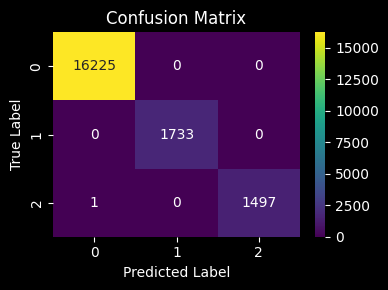

In [6]:
# XGBoost Classifier
from xgboost import XGBClassifier

# Define pipeline and fit model
pipeline = make_pipeline(StandardScaler(), XGBClassifier())
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred, zero_division=1))
plot_confusion_matrix(y_test, y_pred)

In [7]:
# LightGBM Classifier

In [8]:
# CatBoost Classifier

In [9]:
# Extra Trees Classifier

In [10]:
# Stochastic Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16225
           1       1.00      1.00      1.00      1733
           2       1.00      1.00      1.00      1498

    accuracy                           1.00     19456
   macro avg       1.00      1.00      1.00     19456
weighted avg       1.00      1.00      1.00     19456



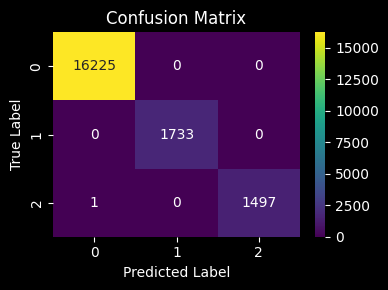

In [11]:
# Histogram-based Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Define pipeline and fit model
pipeline = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred, zero_division=1))
plot_confusion_matrix(y_test, y_pred)

In [12]:
# NGBoost Classifier

In [13]:
# MART Classifier